# Importing Necessary Packages

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import LSTM, LeakyReLU, Dropout, Dense
from pandas_datareader.data import DataReader
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
import pandas_datareader as pdr
import numpy as np

In [2]:
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
yf.pdr_override()

# One-Step aHead Prediction on AAPL stock

> Indented block

> Indented block





In [ ]:
now = datetime.now()
end = datetime(now.year, now.month-3, now.day)
start = datetime(end.year - 15, end.month, end.day)

# Get the stock quote
df = yf.download('AAPL', start=start, end=end)
# Show teh data
df.head(2)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-09-12,5.389643,5.389643,5.232143,5.319286,4.509051,793027200
2008-09-15,5.072500,5.274643,5.012857,5.012857,4.249298,920634400


In [ ]:
df.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-07,175.179993,178.210007,173.539993,177.559998,177.326385,112488800
2023-09-08,178.350006,180.240005,177.789993,178.179993,177.945557,65551300


In [ ]:
# Create a new dataframe with only the 'Close column
data = df.filter(['Adj Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on (vs validation)
training_data_len = int(np.ceil( len(dataset) * .9 ))

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Model Arciturcute

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape = (30, 1), return_sequences=True))
model.add(tf.keras.layers.Dropout (0.2))
model.add(tf.keras.layers.LSTM(50, return_sequences=True))
model.add(tf.keras.layers.Dropout (0.2))
model.add(tf.keras.layers.LSTM(50, return_sequences=True))
model.add(tf.keras.layers.Dropout (0.2))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dropout (0.2))
model.add(tf.keras.layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)               

### Experimenting with Window Lenght

In [ ]:
win_lengths = [7,21,30]
data_train_dict = {}
data_test_dict = {}

In [ ]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]

for window_length in win_lengths:

    # Split the data into x_train and y_train data sets
    x_train = []
    y_train = []

    for i in range(window_length, len(train_data)):
        x_train.append(train_data[i-window_length:i, 0])
        y_train.append(train_data[i, 0])

    # Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    data_train_dict[window_length] = [x_train,y_train]

NameError: ignored

In [ ]:
# Create the testing data set
for window_length in win_lengths:
    test_data = scaled_data[training_data_len - window_length: , :]

    x_test = []
    y_test = []
    #y_test = dataset[training_data_len:, :]

    for i in range(window_length, len(test_data)):
        x_test.append(test_data[i-window_length:i, 0])
        y_test.append(test_data[i, 0])

    # Convert the data to a numpy array
    x_test, y_test = np.array(x_test), np.array(y_test)
    #x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    data_test_dict[window_length] = [x_test,y_test]

In [ ]:
trained_models = {}

for window_length in win_lengths:

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(50, input_shape = (window_length, 1), return_sequences=True))
    model.add(tf.keras.layers.Dropout (0.2))
    model.add(tf.keras.layers.LSTM(50, return_sequences=True))
    model.add(tf.keras.layers.Dropout (0.2))
    model.add(tf.keras.layers.LSTM(50, return_sequences=True))
    model.add(tf.keras.layers.Dropout (0.2))
    model.add(tf.keras.layers.LSTM(50, return_sequences=False))
    model.add(tf.keras.layers.Dropout (0.2))
    model.add(tf.keras.layers.Dense(1))


    model.compile(loss=tf.losses.MeanSquaredError(),
                 optimizer=tf.optimizers.Adam(learning_rate=0.001),
                 metrics=[tf.metrics.MeanAbsoluteError()])

    # Train the model
    history = model.fit(data_train_dict[window_length][0], data_train_dict[window_length][1],
                        batch_size=128,
                        epochs=25,
                        validation_data=(data_test_dict[window_length][0], data_test_dict[window_length][1]),
                        verbose = 0)

    # Save the model
    trained_models[window_length] = [model,history]
    print(f'Model and history for window_length {window_length} saved!')

Model and history for window_length 7 saved!
Model and history for window_length 21 saved!
Model and history for window_length 30 saved!


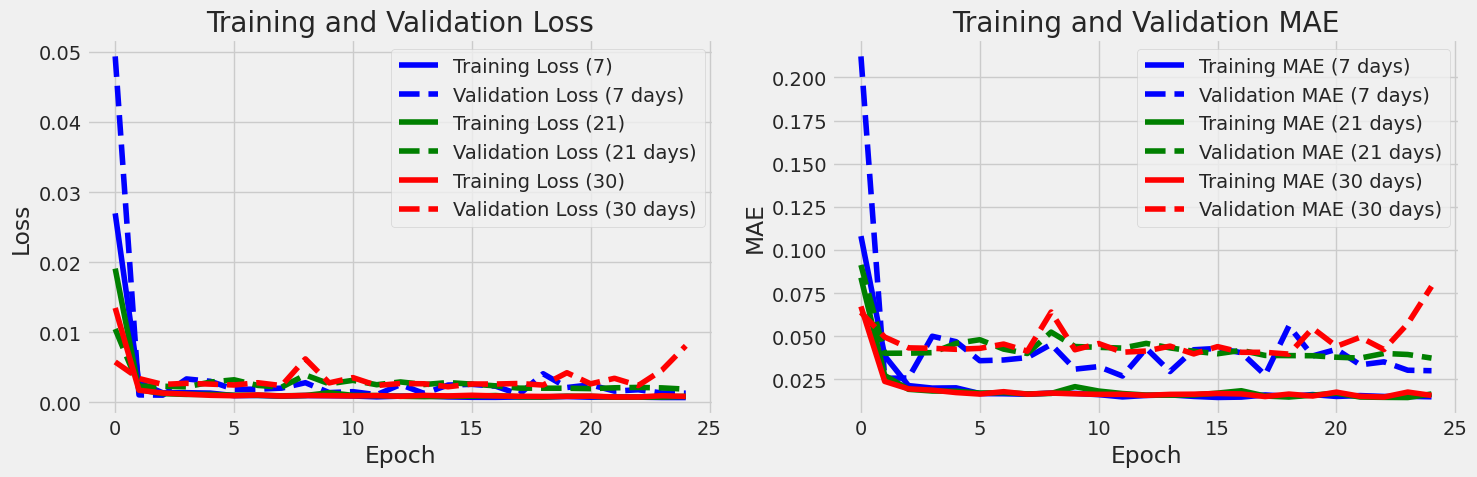

In [ ]:
import matplotlib.pyplot as plt

# Define colors for each window size
colors = {7: 'blue', 21: 'green', 30: 'red'}

# Define line styles for training and validation
line_styles = {'Training': '-', 'Validation': '--'}

# Create subplots outside the loop
fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi= 100)

for window_length in win_lengths:
    window_key = window_length

    # Plot training loss
    axs[0].plot(trained_models[window_length][1].history['loss'],
                label=f'Training Loss ({window_length})',
                color=colors[window_key],
                linestyle=line_styles['Training'])

    # Plot validation loss
    axs[0].plot(trained_models[window_length][1].history['val_loss'],
                label=f'Validation Loss ({window_length} days)',
                color=colors[window_key],
                linestyle=line_styles['Validation'])

    # Plot training MAE
    axs[1].plot(trained_models[window_length][1].history['mean_absolute_error'],
                label=f'Training MAE ({window_length} days)',
                color=colors[window_key],
                linestyle=line_styles['Training'])

    # Plot validation MAE
    axs[1].plot(trained_models[window_length][1].history['val_mean_absolute_error'],
                label=f'Validation MAE ({window_length} days)',
                color=colors[window_key],
                linestyle=line_styles['Validation'])

# Set titles and labels
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].set_title('Training and Validation MAE')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
predictions_dict = {}
rmse_dict = {}

for window_length in win_lengths:


    predictions = trained_models[window_length][0].predict(data_test_dict[window_length][0])
    predictions = scaler.inverse_transform(predictions)
    predictions_dict[window_length] = predictions
    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - data_test_dict[window_length][1]) ** 2)))
    rmse_dict[window_length] = rmse

12/12 [==============================] - 2s 15ms/step


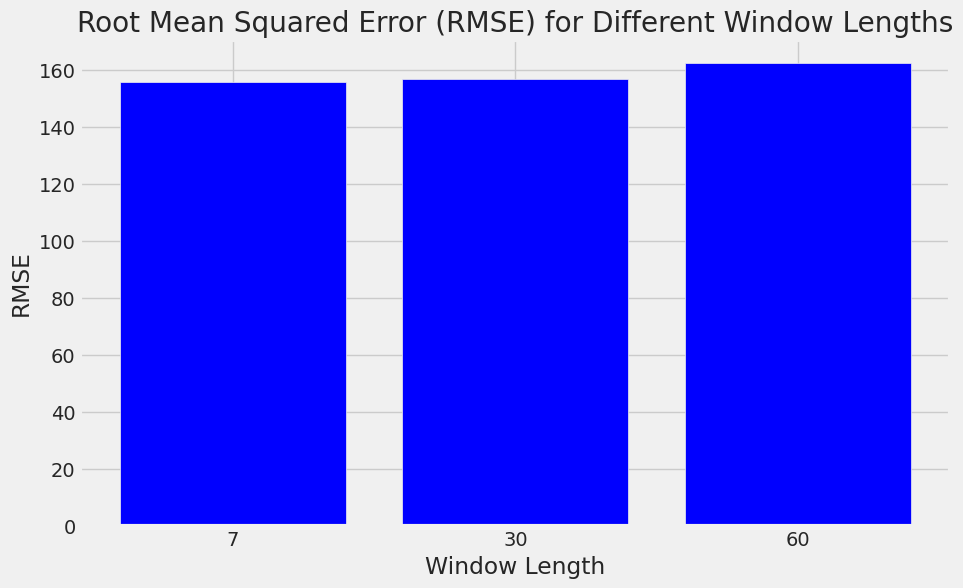

In [ ]:
import matplotlib.pyplot as plt

# Assuming rmse_dict is already defined

# Extracting window_lengths and corresponding RMSE values
window_lengths = list(map(str,rmse_dict.keys()))
rmse_values = list(rmse_dict.values())

# Plotting RMSE values with window length labels
plt.figure(figsize=(10, 6))
plt.bar(window_lengths, rmse_values, color='blue')
plt.title('Root Mean Squared Error (RMSE) for Different Window Lengths')
plt.xlabel('Window Length')
plt.ylabel('RMSE')
plt.show()

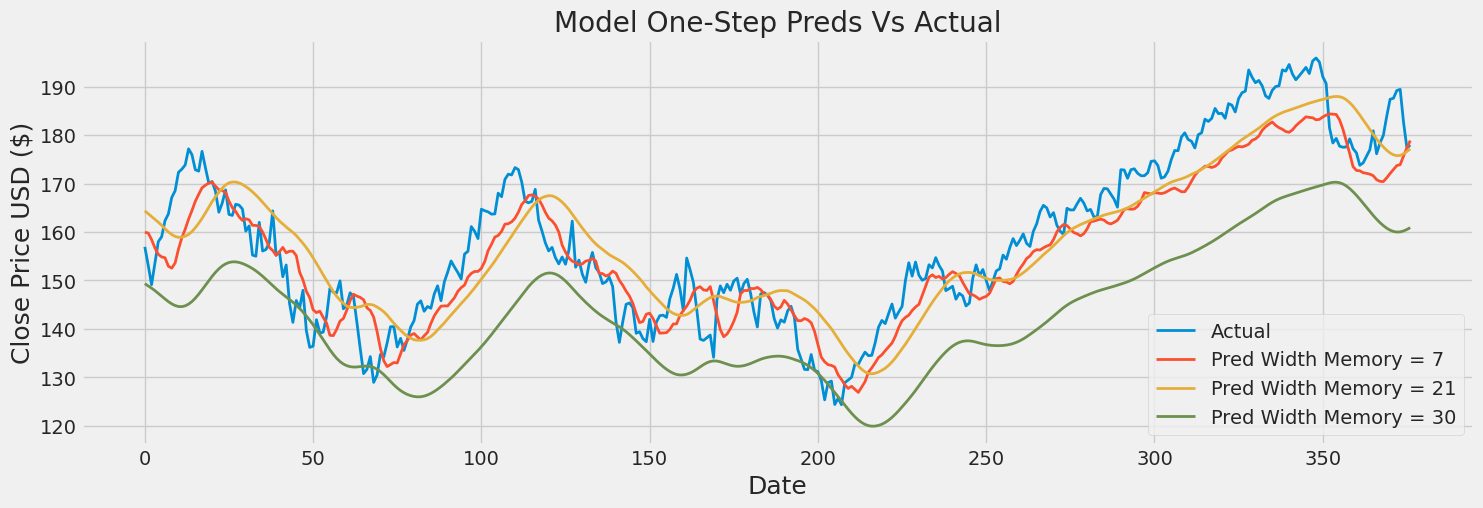

In [ ]:
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(dataset[training_data_len: , :], linewidth=2, label='Actual')

for window_length in win_lengths:
    model_pred = predictions_dict[window_length]
    plt.plot(model_pred, linewidth=2, label=f'Pred Width Memory = {window_length}')


plt.title('Model One-Step Preds Vs Actual')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(loc='lower right')
plt.show()


### Batch Size Experimentation

In [ ]:
batch_sizes = [64,128,256]
win_lengths = [21]
data_train_dict = {}
data_test_dict = {}

In [ ]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]

for window_length in win_lengths:

    # Split the data into x_train and y_train data sets
    x_train = []
    y_train = []

    for i in range(window_length, len(train_data)):
        x_train.append(train_data[i-window_length:i, 0])
        y_train.append(train_data[i, 0])

    # Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    data_train_dict[window_length] = [x_train,y_train]

In [ ]:
# Create the testing data set
for window_length in win_lengths:
    test_data = scaled_data[training_data_len - window_length: , :]

    x_test = []
    y_test = []
    #y_test = dataset[training_data_len:, :]

    for i in range(window_length, len(test_data)):
        x_test.append(test_data[i-window_length:i, 0])
        y_test.append(test_data[i, 0])

    # Convert the data to a numpy array
    x_test, y_test = np.array(x_test), np.array(y_test)
    #x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    data_test_dict[window_length] = [x_test,y_test]

In [ ]:
trained_models = {}

for batch_size in batch_sizes:

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(50, input_shape = (21, 1), return_sequences=True))
    model.add(tf.keras.layers.Dropout (0.2))
    model.add(tf.keras.layers.LSTM(50, return_sequences=True))
    model.add(tf.keras.layers.Dropout (0.2))
    model.add(tf.keras.layers.LSTM(50, return_sequences=True))
    model.add(tf.keras.layers.Dropout (0.2))
    model.add(tf.keras.layers.LSTM(50, return_sequences=False))
    model.add(tf.keras.layers.Dropout (0.2))
    model.add(tf.keras.layers.Dense(1))


    model.compile(loss=tf.losses.MeanSquaredError(),
                 optimizer=tf.optimizers.Adam(learning_rate=0.001),
                 metrics=[tf.metrics.MeanAbsoluteError()])

    # Train the model
    history = model.fit(data_train_dict[21][0], data_train_dict[21][1],
                        batch_size=batch_size,
                        epochs=25,
                        validation_data=(data_test_dict[21][0], data_test_dict[21][1]),
                        verbose = 0)

    # Save the model
    trained_models[batch_size] = [model,history]
    print(f'Model and history for window_length {window_length} saved!')

Model and history for window_length 21 saved!
Model and history for window_length 21 saved!
Model and history for window_length 21 saved!


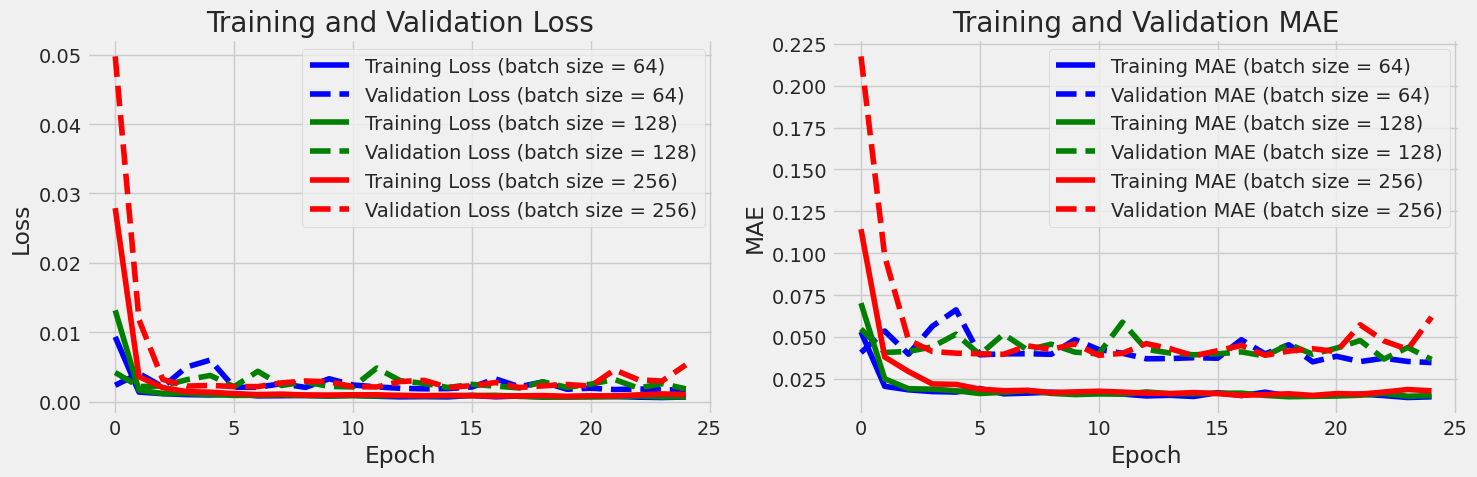

In [ ]:
# Define colors for each window size
colors = {64: 'blue', 128: 'green', 256: 'red'}

# Define line styles for training and validation
line_styles = {'Training': '-', 'Validation': '--'}

# Create subplots outside the loop
fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi = 100)

for batch_size in batch_sizes:
    window_key = batch_size

    # Plot training loss
    axs[0].plot(trained_models[batch_size][1].history['loss'],
                label=f'Training Loss (batch size = {batch_size})',
                color=colors[window_key],
                linestyle=line_styles['Training'])

    # Plot validation loss
    axs[0].plot(trained_models[batch_size][1].history['val_loss'],
                label=f'Validation Loss (batch size = {batch_size})',
                color=colors[window_key],
                linestyle=line_styles['Validation'])

    # Plot training MAE
    axs[1].plot(trained_models[batch_size][1].history['mean_absolute_error'],
                label=f'Training MAE (batch size = {batch_size})',
                color=colors[window_key],
                linestyle=line_styles['Training'])

    # Plot validation MAE
    axs[1].plot(trained_models[batch_size][1].history['val_mean_absolute_error'],
                label=f'Validation MAE (batch size = {batch_size})',
                color=colors[window_key],
                linestyle=line_styles['Validation'])

# Set titles and labels
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].set_title('Training and Validation MAE')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
predictions_dict = {}
rmse_dict = {}

for batch_size in batch_sizes:

    # Get the models predicted price values
    predictions = trained_models[batch_size][0].predict(data_test_dict[win_lengths[0]][0])
    predictions = scaler.inverse_transform(predictions)
    predictions_dict[batch_size] = predictions
    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - data_test_dict[win_lengths[0]][1]) ** 2)))
    rmse_dict[batch_size] = rmse

12/12 [==============================] - 2s 12ms/step


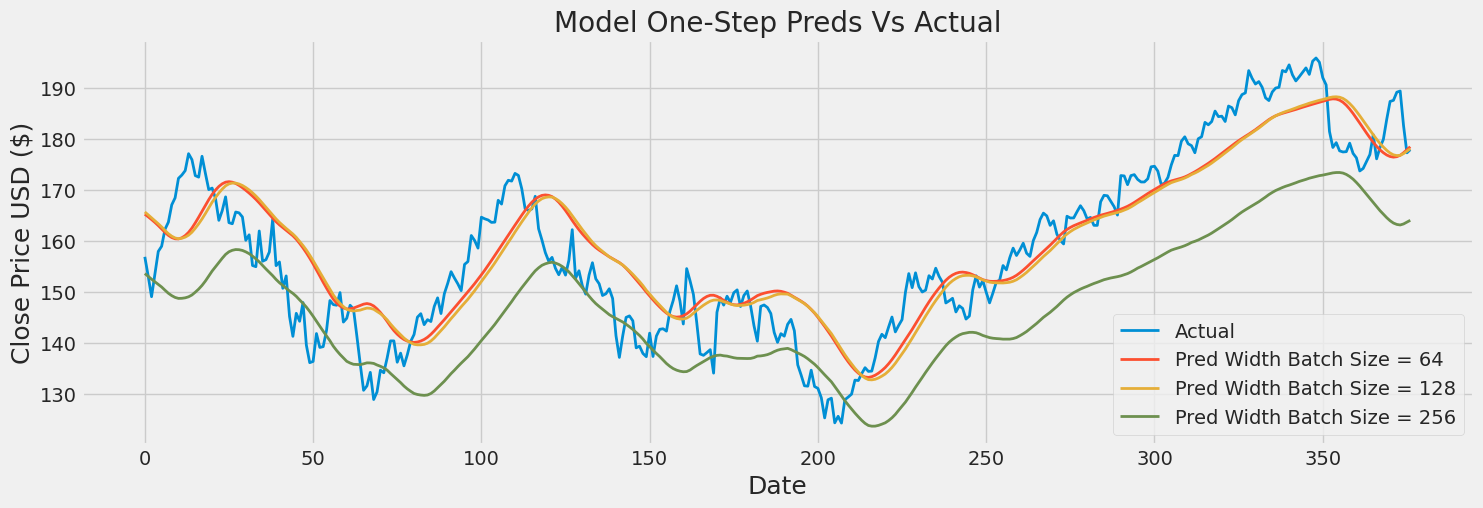

In [ ]:
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(dataset[training_data_len: , :], linewidth=2, label='Actual')

for batch_size in batch_sizes:
    model_pred = predictions_dict[batch_size]
    plt.plot(model_pred, linewidth=2, label=f'Pred Width Batch Size = {batch_size}')


plt.title('Model One-Step Preds Vs Actual')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(loc='lower right')
plt.show()


In [ ]:
trained_models = {}

for batch_size in batch_sizes:

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(50, input_shape = (win_lengths[0], 1), return_sequences=True))
    model.add(tf.keras.layers.Dropout (0.2))
    model.add(tf.keras.layers.LSTM(50, return_sequences=True))
    model.add(tf.keras.layers.Dropout (0.2))
    model.add(tf.keras.layers.LSTM(50, return_sequences=True))
    model.add(tf.keras.layers.Dropout (0.2))
    model.add(tf.keras.layers.LSTM(50, return_sequences=False))
    model.add(tf.keras.layers.Dropout (0.2))
    model.add(tf.keras.layers.Dense(1))


    model.compile(loss=tf.losses.MeanSquaredError(),
                 optimizer=tf.optimizers.Adam(learning_rate=0.001),
                 metrics=[tf.metrics.MeanAbsoluteError()])

    # Train the model
    history = model.fit(data_train_dict[win_lengths[0]][0], data_train_dict[win_lengths[0]][1],
                        batch_size=batch_size,
                        epochs=25,
                        validation_data=(data_test_dict[win_lengths[0]][0], data_test_dict[win_lengths[0]][1]),
                        verbose = 0)

    # Save the model
    trained_models[batch_size] = [model,history]
    print(f'Model and history for window_length {batch_size} saved!')

Model and history for window_length 64 saved!
Model and history for window_length 128 saved!
Model and history for window_length 254 saved!


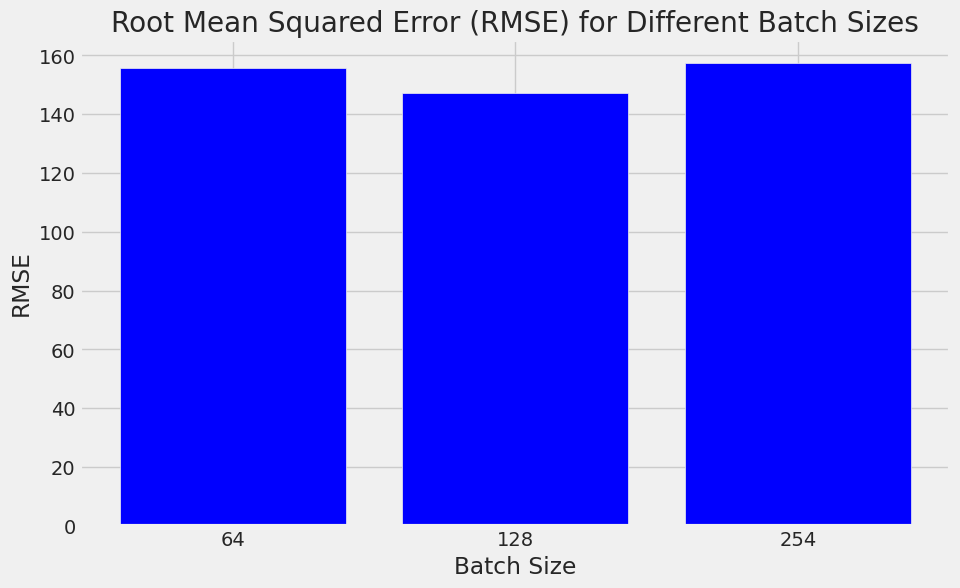

In [ ]:
import matplotlib.pyplot as plt

# Assuming rmse_dict is already defined

# Extracting window_lengths and corresponding RMSE values
batch_sizes = list(map(str,rmse_dict.keys()))
rmse_values = list(rmse_dict.values())

# Plotting RMSE values with window length labels
plt.figure(figsize=(10, 6))
plt.bar(batch_sizes, rmse_values, color='blue')
plt.title('Root Mean Squared Error (RMSE) for Different Batch Sizes')
plt.xlabel('Batch Size')
plt.ylabel('RMSE')
plt.show()

# Experimentation with learning rate

In [ ]:
learning_rates = [0.1,0.01,0.001]
win_lengths = [21]
#data_train_dict = {}
#data_test_dict = {}

In [ ]:
trained_models = {}

for lr in learning_rates:

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(50, input_shape = (win_lengths[0], 1), return_sequences=True))
    model.add(tf.keras.layers.Dropout (0.2))
    model.add(tf.keras.layers.LSTM(50, return_sequences=True))
    model.add(tf.keras.layers.Dropout (0.2))
    model.add(tf.keras.layers.LSTM(50, return_sequences=True))
    model.add(tf.keras.layers.Dropout (0.2))
    model.add(tf.keras.layers.LSTM(50, return_sequences=False))
    model.add(tf.keras.layers.Dropout (0.2))
    model.add(tf.keras.layers.Dense(1))


    model.compile(loss=tf.losses.MeanSquaredError(),
                 optimizer=tf.optimizers.Adam(learning_rate=lr),
                 metrics=[tf.metrics.MeanAbsoluteError()])

    # Train the model
    history = model.fit(data_train_dict[win_lengths[0]][0], data_train_dict[win_lengths[0]][1],
                        batch_size=128,
                        epochs=25,
                        validation_data=(data_test_dict[win_lengths[0]][0], data_test_dict[win_lengths[0]][1]),
                        verbose = 0)

    # Save the model
    trained_models[lr] = [model,history]
    print(f'Model and history for window_length {lr} saved!')

Model and history for window_length 0.1 saved!
Model and history for window_length 0.01 saved!
Model and history for window_length 0.001 saved!


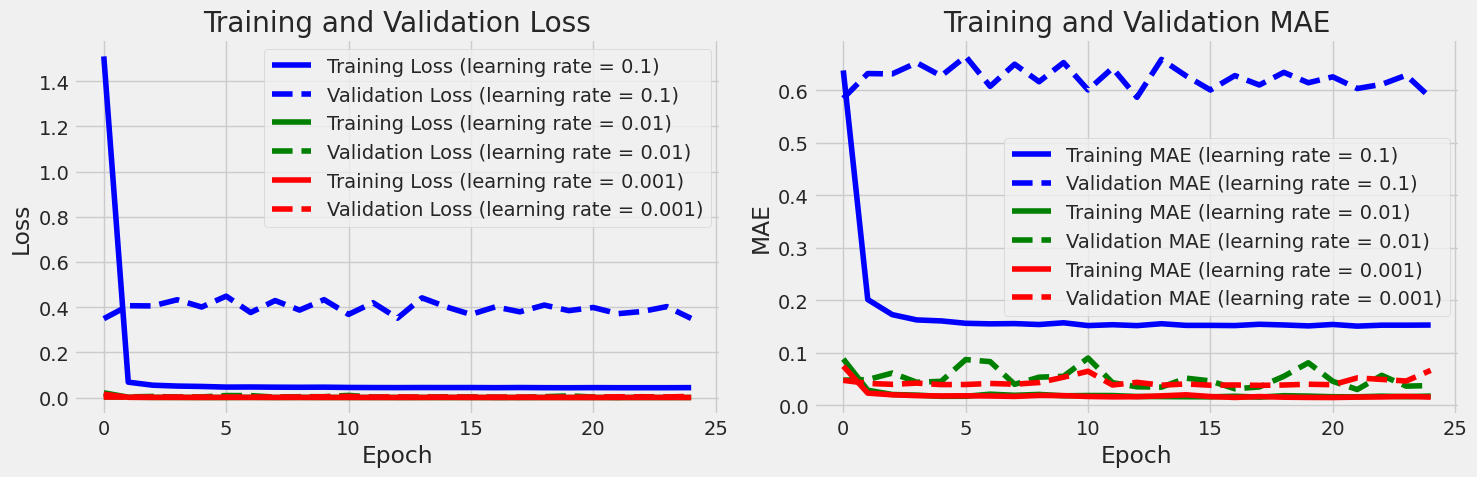

In [ ]:
# Define colors for each window size
colors = {0.1: 'blue', 0.01: 'green', 0.001: 'red'}

# Define line styles for training and validation
line_styles = {'Training': '-', 'Validation': '--'}

# Create subplots outside the loop
fig, axs = plt.subplots(1, 2, figsize=(15, 5), dpi= 100)

for lr in learning_rates:
    window_key = lr

    # Plot training loss
    axs[0].plot(trained_models[lr][1].history['loss'],
                label=f'Training Loss (learning rate = {lr})',
                color=colors[window_key],
                linestyle=line_styles['Training'])

    # Plot validation loss
    axs[0].plot(trained_models[lr][1].history['val_loss'],
                label=f'Validation Loss (learning rate = {lr})',
                color=colors[window_key],
                linestyle=line_styles['Validation'])

    # Plot training MAE
    axs[1].plot(trained_models[lr][1].history['mean_absolute_error'],
                label=f'Training MAE (learning rate = {lr})',
                color=colors[window_key],
                linestyle=line_styles['Training'])

    # Plot validation MAE
    axs[1].plot(trained_models[lr][1].history['val_mean_absolute_error'],
                label=f'Validation MAE (learning rate = {lr})',
                color=colors[window_key],
                linestyle=line_styles['Validation'])

# Set titles and labels
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].set_title('Training and Validation MAE')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
predictions_dict = {}
rmse_dict = {}
learning_rates = [0.1,0.01,0.001]

for lr in learning_rates:

    # Get the models predicted price values
    predictions = trained_models[lr][0].predict(data_test_dict[win_lengths[0]][0])
    predictions = scaler.inverse_transform(predictions)
    predictions_dict[lr] = predictions
    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - data_test_dict[win_lengths[0]][1]) ** 2)))
    rmse_dict[lr] = rmse

12/12 [==============================] - 2s 13ms/step


In [ ]:
rmse_dict

{0.1: 21.32478689541408, 0.01: 161.04352938959576, 0.001: 159.54727283168594}

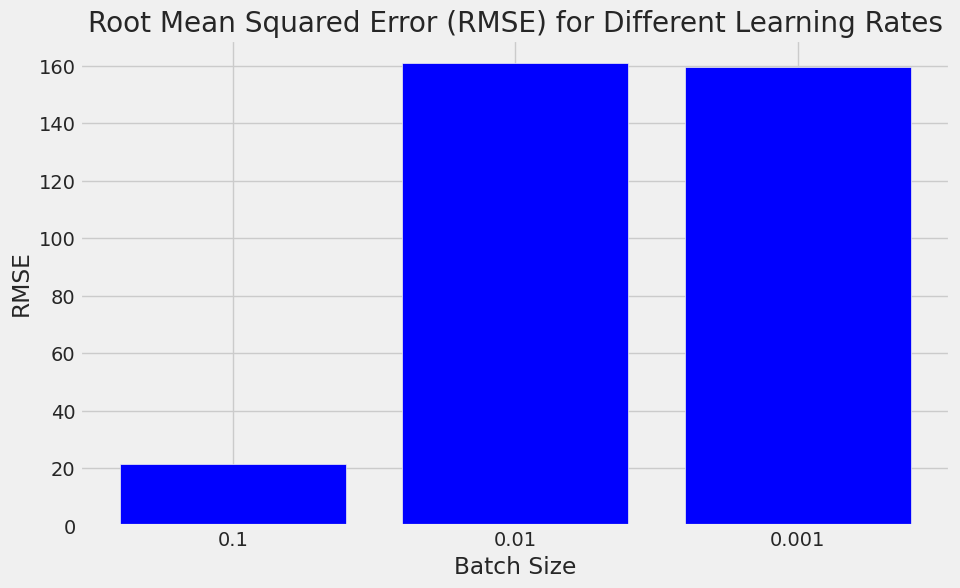

In [ ]:
import matplotlib.pyplot as plt

# Assuming rmse_dict is already defined

# Extracting window_lengths and corresponding RMSE values
learning_rates = list(map(str,rmse_dict.keys()))
rmse_values = list(rmse_dict.values())

# Plotting RMSE values with window length labels
plt.figure(figsize=(10, 6))
plt.bar(learning_rates, rmse_values, color='blue')
plt.title('Root Mean Squared Error (RMSE) for Different Learning Rates')
plt.xlabel('Batch Size')
plt.ylabel('RMSE')
plt.show()

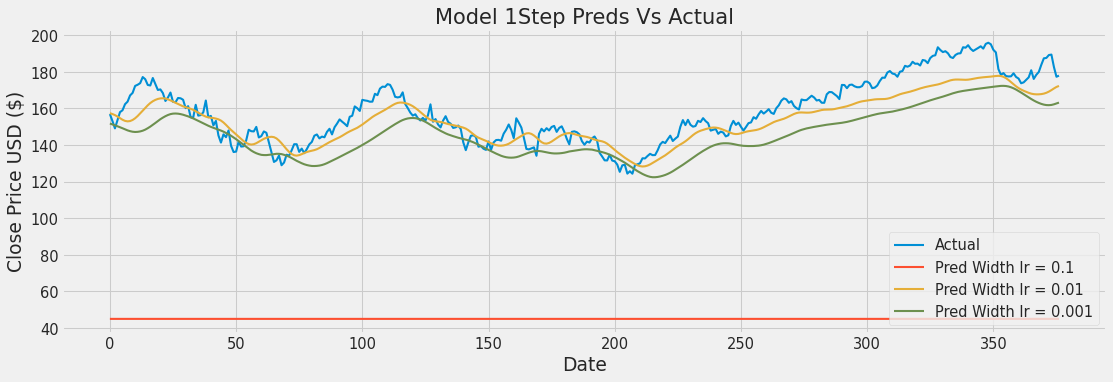

In [ ]:
plt.figure(figsize=(16, 5), dpi=75)
plt.plot(dataset[training_data_len: , :], linewidth=2, label='Actual')

for lr in learning_rates:
    model_pred = predictions_dict[float(lr)]
    plt.plot(model_pred, linewidth=2, label=f'Pred Width lr = {lr}')


plt.title('Model 1Step Preds Vs Actual')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(loc='lower right')
plt.show()

# Prediction

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape = (21, 1), return_sequences=True))
model.add(tf.keras.layers.Dropout (0.2))
model.add(tf.keras.layers.LSTM(50, return_sequences=True))
model.add(tf.keras.layers.Dropout (0.2))
model.add(tf.keras.layers.LSTM(50, return_sequences=True))
model.add(tf.keras.layers.Dropout (0.2))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dropout (0.2))
model.add(tf.keras.layers.Dense(1))


model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=0.01),
              metrics=[tf.metrics.MeanAbsoluteError()])

# Train the model
history = model.fit(data_train_dict[21][0], data_train_dict[21][1],
                    batch_size=128,
                    epochs=100,
                    validation_data=(data_test_dict[21][0], data_test_dict[21][1]),
                    verbose = 0)

In [ ]:
# Get the models predicted price values
model_predictions = model.predict(data_test_dict[21][0])
model_predictions = scaler.inverse_transform(model_predictions)

12/12 [==============================] - 3s 14ms/step


In [ ]:
test_data = dataset[training_data_len: , :]

my_test_df = pd.DataFrame(test_data, columns=['Adj Close'])

In [ ]:
ma_day = [7, 21, 30]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    my_test_df[column_name] = my_test_df['Adj Close'].rolling(ma).mean()

In [ ]:
my_test_df.head(10)

,Adj Close,MA for 7 days,MA for 21 days,MA for 30 days
0,156.928925,NaN,NaN,NaN
1,153.176971,NaN,NaN,NaN
2,149.108231,NaN,NaN,NaN
3,153.533371,NaN,NaN,NaN
4,157.988220,NaN,NaN,NaN
5,159.007843,NaN,NaN,NaN
6,162.334137,156.011100,NaN,NaN
7,163.720093,156.981267,NaN,NaN
8,167.125565,158.973923,NaN,NaN
9,168.501587,161.744402,NaN,NaN


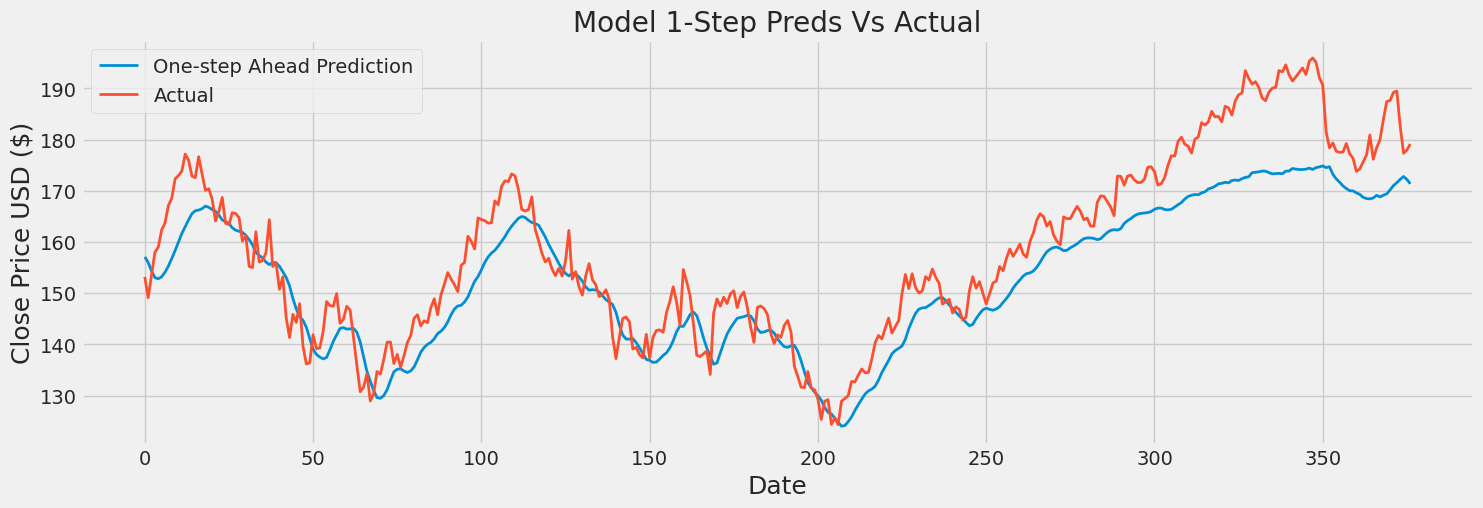

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'dataset', 'predictions_dict', 'lr', and 'my_test_df' are defined

plt.figure(figsize=(16, 5), dpi=100)

# Plot actual 'Adj Close'
#plt.plot(dataset['Adj Close'][training_data_len:], linewidth=2, label='Actual')

# Plot one-step ahead prediction
#model_pred = predictions_dict[float(lr)]
plt.plot(model_predictions, linewidth=2, label='One-step Ahead Prediction')

# Plot additional columns from my_test_df
plt.plot(dataset[training_data_len: , :], linewidth=2, label='Actual')
#plt.plot(my_test_df['MA for 7 days'], linewidth=1, label='MA for 7 days from my_test_df')
#plt.plot(my_test_df['MA for 21 days'], linewidth=1, label='Moving Average for 21 days')
#plt.plot(my_test_df['MA for 30 days'], linewidth=1, label='MA for 30 days from my_test_df')

plt.title('APPLE')
plt.title('Model 1-Step Preds Vs Actual')

plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE
mae = mean_absolute_error(dataset[training_data_len: , :], model_predictions)

# Calculate MAPE
mape = np.mean(np.abs((dataset[training_data_len: , :] - model_predictions) / dataset[training_data_len: , :])) * 100

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(dataset[training_data_len: , :], model_predictions))

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"RMSE: {rmse}")



MAE: 6.66630483369296
MAPE: 4.042852638096884
RMSE: 8.234074117267191


In [ ]:
my_test_df['MA for 21 days'].fillna(method='bfill', inplace=True)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


# Calculate MAE
mae = mean_absolute_error(dataset[training_data_len: , :], my_test_df['MA for 21 days'])

# Calculate MAPE
mape = np.mean(np.abs((dataset[training_data_len: , :] - my_test_df['MA for 21 days']) / dataset[training_data_len: , :])) * 100

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(dataset[training_data_len: , :], my_test_df['MA for 21 days']))

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"RMSE: {rmse}")


ValueError: ignored

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
now = datetime.now()
end = datetime(now.year, now.month-3, now.day)
start = datetime(end.year - 15, end.month, end.day)

# Get the stock quote
df =  yf.download('AAPL', start=start, end=end)
# Show teh data
df.head(2)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-09-12,5.389643,5.389643,5.232143,5.319286,4.509051,793027200
2008-09-15,5.072500,5.274643,5.012857,5.012857,4.249298,920634400


In [ ]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.9)
train, test = df[:train_size], df[train_size:]

def arima_predictions(train, test):
    history = list(train['Adj Close'])
    predictions = []

    for t in range(len(test)):
        model = ARIMA(history, order=(7,1,0))
        model_fit = model.fit()

        yhat = model_fit.forecast(steps=1)[0]
        predictions.append(yhat)

        history.append(test['Adj Close'].iloc[t])

    return predictions

# Make predictions
predictions = arima_predictions(train, test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(test['Adj Close'], predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 8.913467913314683


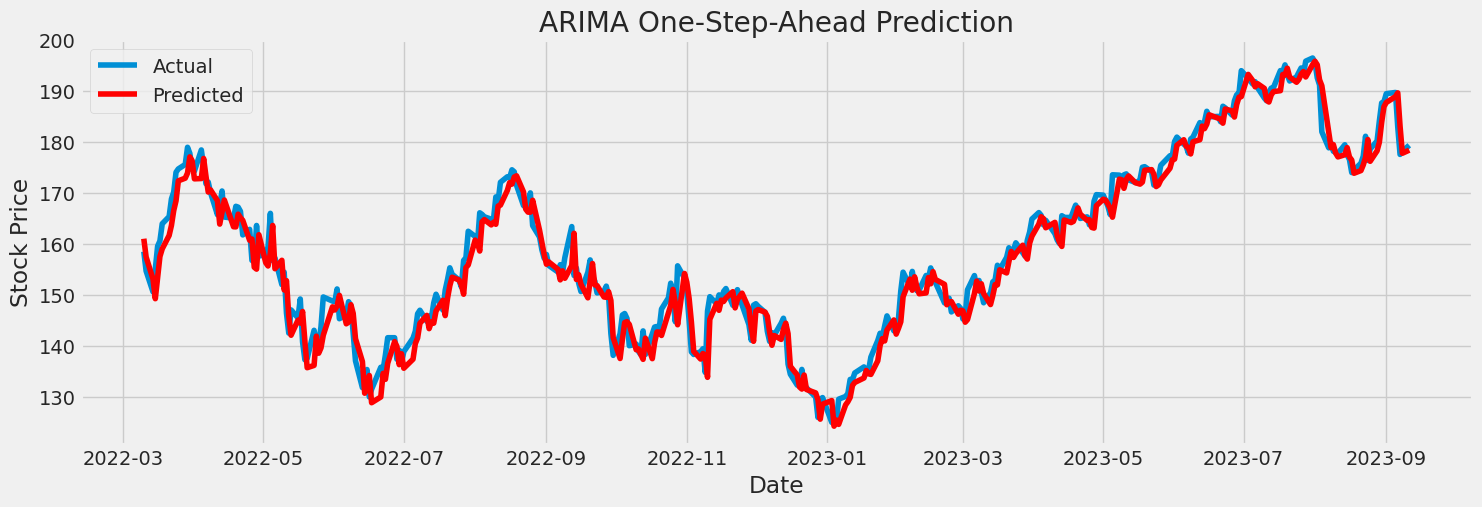

In [ ]:
# Plot the results
plt.figure(figsize=(16,5), dpi = 100)
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('ARIMA One-Step-Ahead Prediction')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE
mae = mean_absolute_error(test['Adj Close'], predictions)

# Calculate MAPE
mape = np.mean(np.abs((test['Adj Close'] - predictions) / test['Adj Close'])) * 100

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Adj Close'], predictions))

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"RMSE: {rmse}")

MAE: 2.277132241408671
MAPE: 1.4794648416710479
RMSE: 2.985543152144126


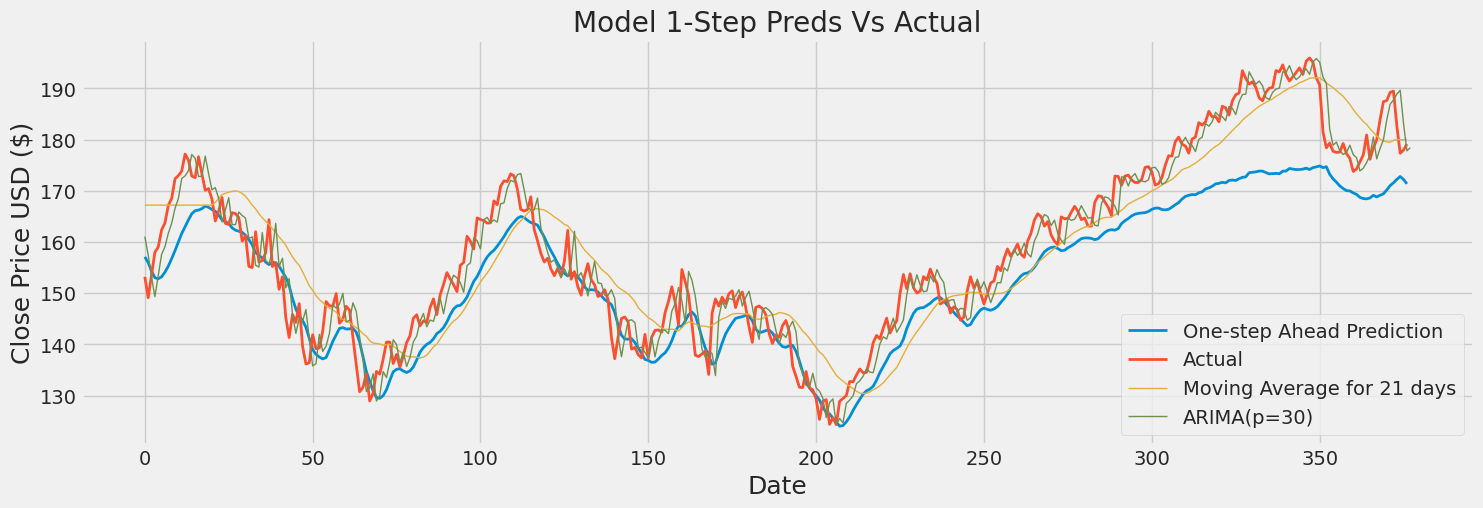

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'dataset', 'predictions_dict', 'lr', and 'my_test_df' are defined

plt.figure(figsize=(16, 5), dpi=100)

# Plot actual 'Adj Close'
#plt.plot(dataset['Adj Close'][training_data_len:], linewidth=2, label='Actual')

# Plot one-step ahead prediction
#model_pred = predictions_dict[float(lr)]
plt.plot(model_predictions, linewidth=2, label='One-step Ahead Prediction')

# Plot additional columns from my_test_df
plt.plot(dataset[training_data_len: , :], linewidth=2, label='Actual')
plt.plot(my_test_df['MA for 21 days'], linewidth=1, label='Moving Average for 21 days')
plt.plot(predictions, linewidth=1, label = 'ARIMA(p=30)')

plt.title('APPLE')
plt.title('Model 1-Step Preds Vs Actual')

plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()
